In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from torch.utils.data import Dataset, DataLoader

from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

In [2]:
from scripts.AutoEncoder import AutoEncoder, AutoEncoderDataset, Encoder, Decoder
from scripts.utils import train_keys, target_keys, ScaleData

In [3]:
train = "/share/rcifdata/jbarr/UKAEAGroupProject/data/QLKNN_train_data.pkl"
df_train = pd.read_pickle(train)
df_train = df_train[train_keys]
df_train, scaler = ScaleData(df_train)

df_train.describe()

,ane,ate,autor,machtor,x,zeff,gammae,q,smag,alpha,ani1,ati0,normni1,ti_te0,lognustar
count,1.767264e+07,1.767264e+07,1.767264e+07,1.767264e+07,1.767264e+07,1.767264e+07,1.767264e+07,1.767264e+07,1.767264e+07,1.767264e+07,1.767264e+07,1.767264e+07,1.767264e+07,1.767264e+07,1.767264e+07
mean,-4.244571e-17,-2.204141e-15,-1.845331e-14,9.872596e-16,1.443307e-15,5.825100e-16,-2.163914e-14,1.116600e-15,-1.048156e-16,8.099105e-16,-8.453134e-16,9.617863e-16,1.647093e-15,1.539637e-14,1.514649e-15
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.384711e+01,-6.585977e+00,-1.884677e+01,-2.065468e+00,-1.685289e+00,-1.270876e+00,-2.605210e+01,-1.226404e+00,-2.207143e+00,-4.272697e+00,-1.542753e+01,-7.614730e+00,-1.810760e+00,-3.966175e+00,-3.129009e+00
25%,-4.040953e-01,-5.670599e-01,-2.922102e-01,-5.312093e-01,-9.628142e-01,-7.966956e-01,4.273997e-02,-7.364278e-01,-6.534275e-01,-4.755039e-01,-3.499717e-01,-5.471105e-01,-2.686078e-01,-1.080478e-01,-7.260516e-01
50%,-2.005211e-01,-2.616720e-01,-2.922102e-01,-5.312093e-01,-1.396549e-01,-1.542101e-01,4.273997e-02,-2.877295e-01,-3.921313e-01,-3.348355e-01,-1.956296e-01,-2.503222e-01,-2.116415e-01,-1.080478e-01,-1.348429e-01
75%,9.590093e-02,2.096182e-01,-2.717016e-02,1.510355e-01,9.351353e-01,5.066278e-01,4.273997e-02,4.397159e-01,2.817471e-01,8.098745e-02,4.703473e-02,2.638433e-01,-9.624531e-02,-1.080478e-01,5.857065e-01
max,1.378378e+01,1.087966e+01,2.907871e+01,5.549705e+00,1.679477e+00,1.529337e+01,1.310198e+01,2.523304e+01,6.818529e+00,1.860037e+01,1.447752e+01,1.282571e+01,2.074059e+01,2.026225e+01,6.969653e+00


In [4]:
full_test = "/share/rcifdata/jbarr/UKAEAGroupProject/data/test_data.pkl"
test = "/share/rcifdata/jbarr/UKAEAGroupProject/data/QLKNN_test_data.pkl"

df_full_test = pd.read_pickle(full_test)
target = df_full_test['Target']

df_full_test = df_full_test[train_keys]
df_full_test,_ = ScaleData(df_full_test, scaler)

df_test = pd.read_pickle(test)
df_test = df_test[train_keys]
df_test,_ = ScaleData(df_test, scaler)

n = 10_000
df_test.describe()

,ane,ate,autor,machtor,x,zeff,gammae,q,smag,alpha,ani1,ati0,normni1,ti_te0,lognustar
count,2.209081e+06,2.209081e+06,2.209081e+06,2.209081e+06,2.209081e+06,2.209081e+06,2.209081e+06,2.209081e+06,2.209081e+06,2.209081e+06,2.209081e+06,2.209081e+06,2.209081e+06,2.209081e+06,2.209081e+06
mean,1.294028e-03,1.000047e-03,9.622261e-04,-1.467884e-03,1.920083e-03,7.137137e-04,8.494952e-04,1.516619e-03,1.549922e-03,7.416861e-04,6.172975e-04,1.285639e-03,-7.268616e-05,9.756333e-04,1.759007e-04
std,1.000815e+00,1.001248e+00,1.009336e+00,9.986958e-01,9.999536e-01,1.000760e+00,9.926095e-01,1.002432e+00,1.001713e+00,1.001943e+00,9.989907e-01,1.001700e+00,9.965351e-01,1.002741e+00,1.001463e+00
min,-1.353957e+01,-6.585977e+00,-1.884677e+01,-2.065468e+00,-1.685289e+00,-1.270876e+00,-2.605210e+01,-1.226404e+00,-2.207143e+00,-4.272697e+00,-1.542753e+01,-7.614730e+00,-1.810760e+00,-3.966175e+00,-3.129009e+00
25%,-4.033442e-01,-5.666384e-01,-2.922102e-01,-5.312093e-01,-9.626737e-01,-7.957460e-01,4.273997e-02,-7.356344e-01,-6.529561e-01,-4.753175e-01,-3.498381e-01,-5.466094e-01,-2.686078e-01,-1.080478e-01,-7.270171e-01
50%,-1.995219e-01,-2.610066e-01,-2.922102e-01,-5.312093e-01,-1.381496e-01,-1.535345e-01,4.273997e-02,-2.869522e-01,-3.904461e-01,-3.346827e-01,-1.952888e-01,-2.497795e-01,-2.116415e-01,-1.080478e-01,-1.353043e-01
75%,9.664207e-02,2.101919e-01,-2.768643e-02,1.465245e-01,9.354394e-01,5.076100e-01,4.273997e-02,4.407709e-01,2.830114e-01,8.240846e-02,4.752986e-02,2.651249e-01,-9.624531e-02,-1.080478e-01,5.869724e-01
max,1.372443e+01,1.087741e+01,2.907871e+01,5.549705e+00,1.679477e+00,1.529337e+01,1.310198e+01,2.523304e+01,6.818529e+00,1.860037e+01,1.447752e+01,1.282307e+01,2.074059e+01,2.026225e+01,6.969653e+00


## Model 1 - AE trained on inputs that give outputs

In [5]:
path = "/share/rcifdata/jbarr/UKAEAGroupProject/logs/AutoEncoder/Run-8/experiment_name=0-epoch=146-val_loss=0.25.ckpt"

model = AutoEncoder.load_from_checkpoint(path, n_input = 15, batch_size = 2048, epochs = 100, learning_rate = 0.002)
encoder = model.encoder

### Evaluate on inputs that give outputs

In [6]:
data_test = torch.from_numpy(df_test.values).float()
outputs_test = encoder.forward(data_test).detach().numpy()

<IPython.core.display.Javascript object>


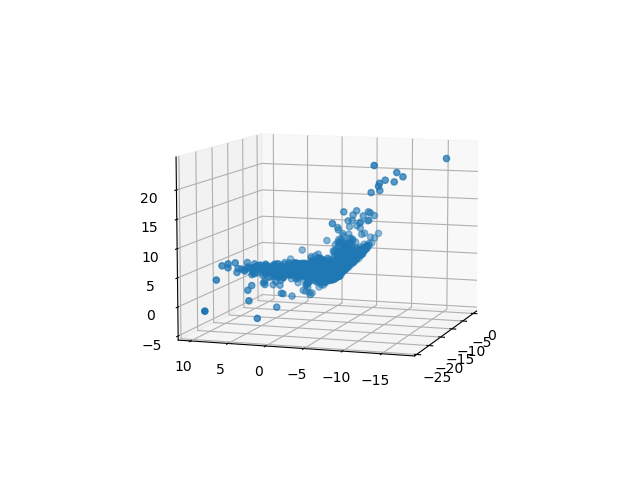

In [7]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(outputs_test[:n,0], outputs_test[:n,1],outputs_test[:n,2])
fig.show()

<IPython.core.display.Javascript object>


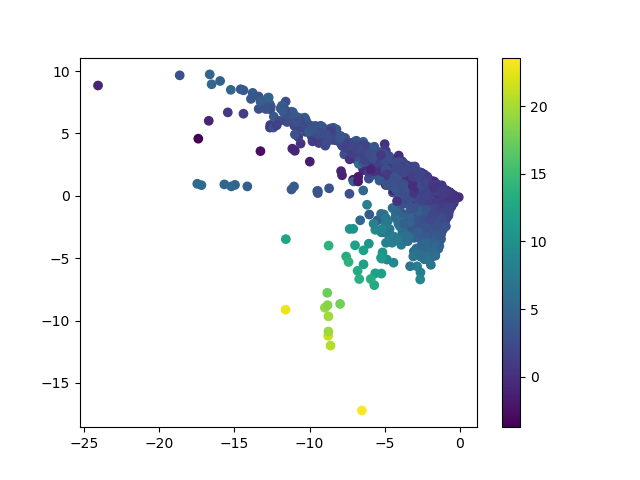

In [8]:
plt.figure()

sc = plt.scatter(outputs_test[:n,0], outputs_test[:n,1], c = outputs_test[:n,2])
plt.colorbar(sc)
plt.show()

### Plot  input and output distributions

In [9]:
AE_output = model.forward(data_test).detach().numpy()
df_ae_output = pd.DataFrame(AE_output, columns = train_keys)
df_ae_output['AE'] = 'Outputs'

df_test_tmp = df_test
df_test_tmp['AE'] = 'Inputs'

In [10]:
df_compare = pd.concat([df_ae_output, df_test_tmp], ignore_index=True)
df_compare_sample = df_compare.sample(n)

<IPython.core.display.Javascript object>


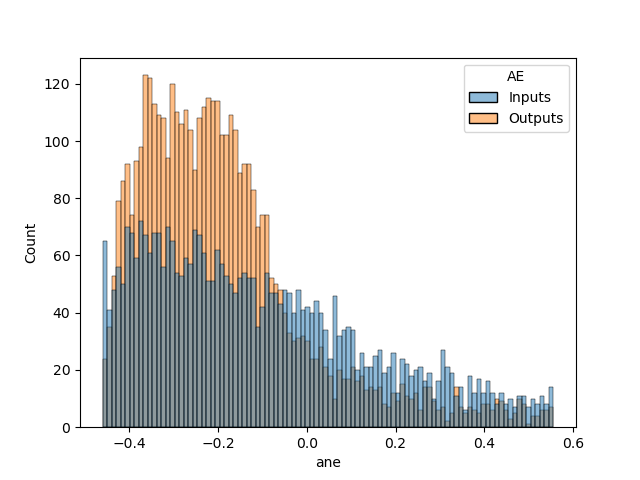

<IPython.core.display.Javascript object>


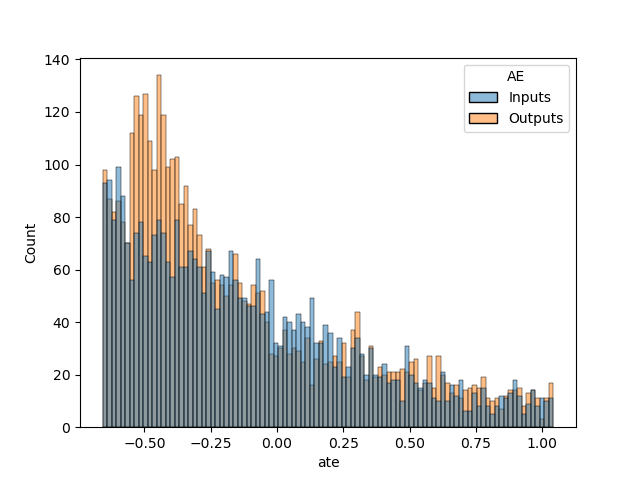

<IPython.core.display.Javascript object>


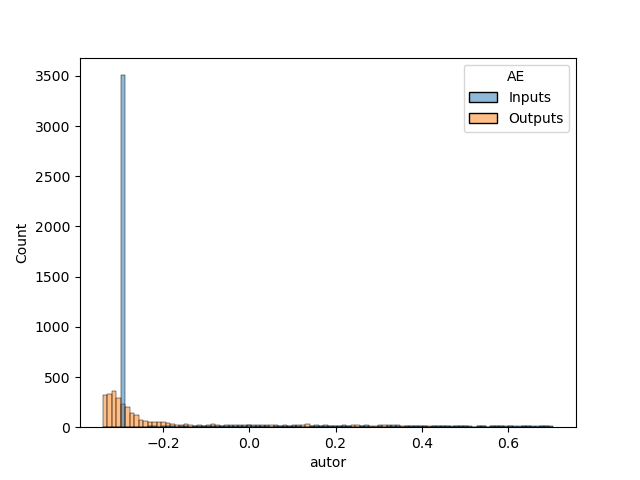

<IPython.core.display.Javascript object>


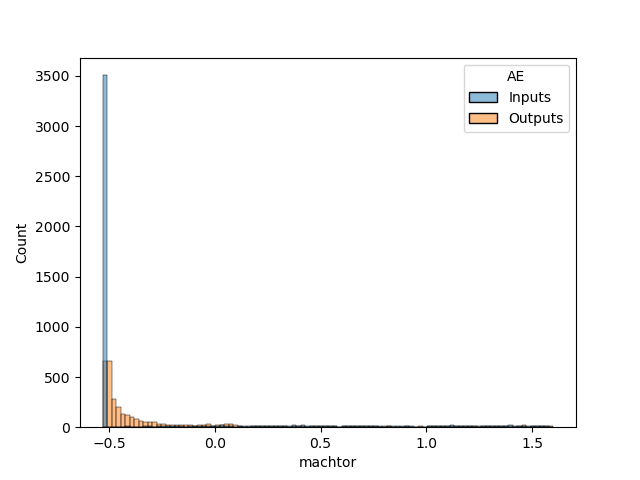

<IPython.core.display.Javascript object>


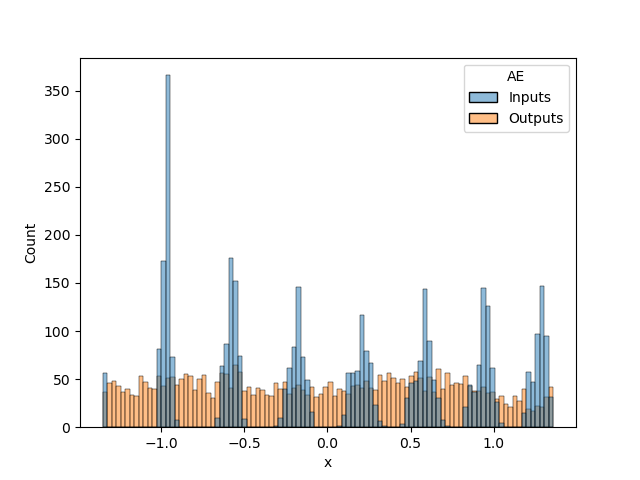

<IPython.core.display.Javascript object>


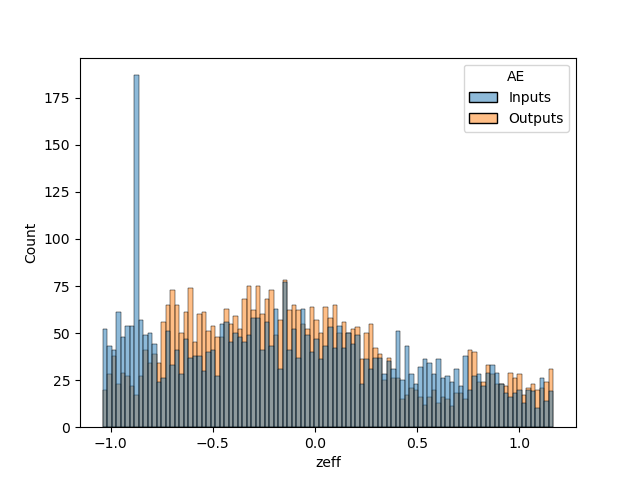

<IPython.core.display.Javascript object>


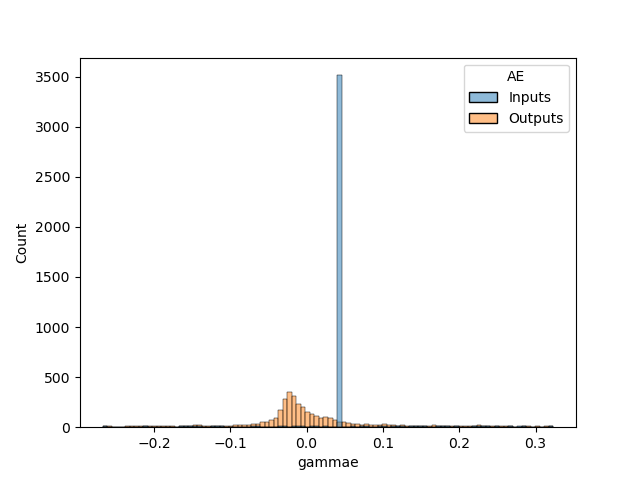

<IPython.core.display.Javascript object>


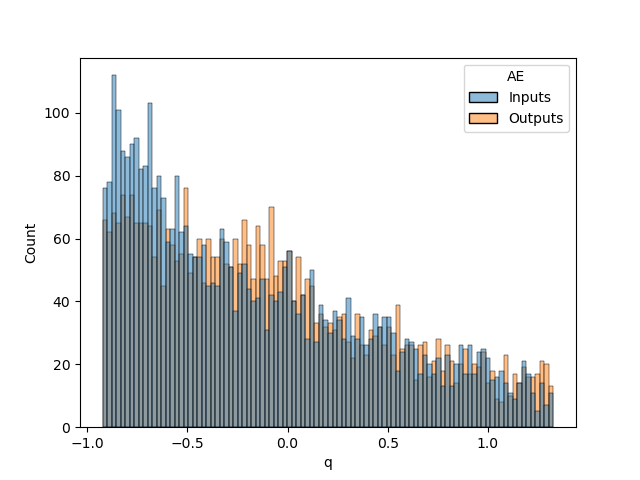

<IPython.core.display.Javascript object>


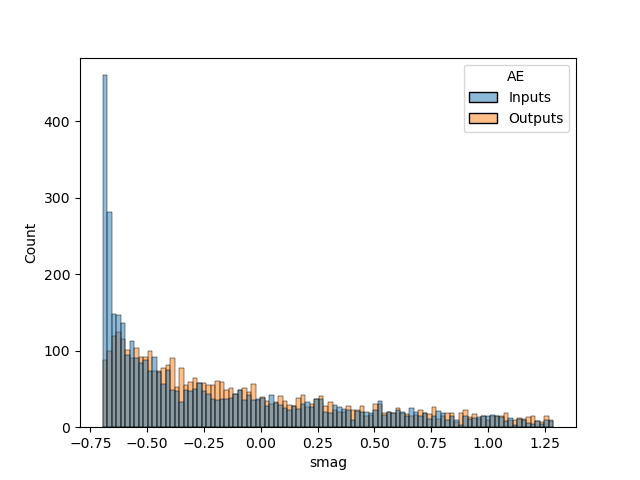

<IPython.core.display.Javascript object>


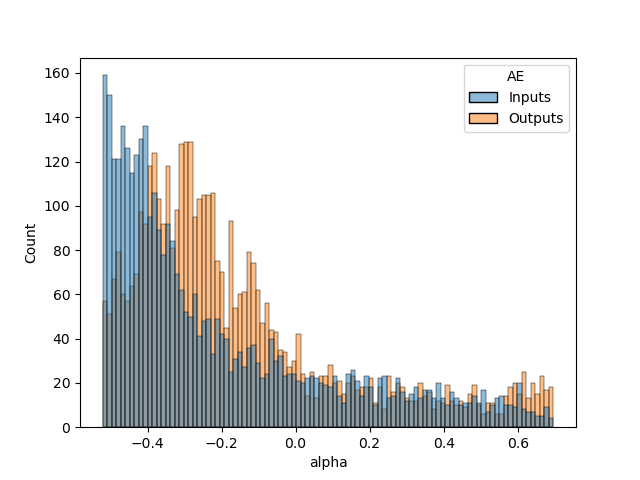

<IPython.core.display.Javascript object>


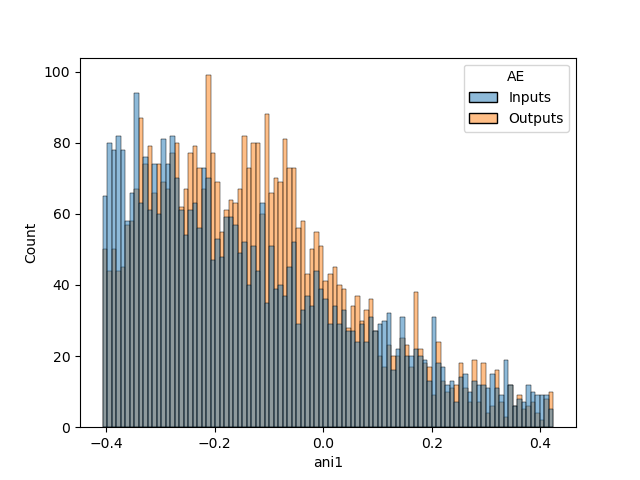

<IPython.core.display.Javascript object>


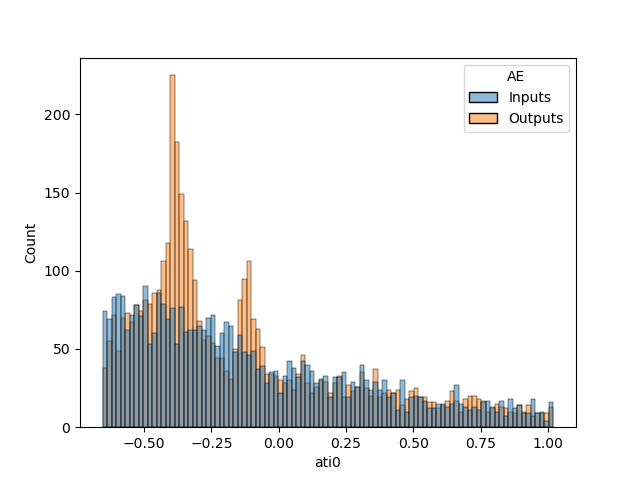

<IPython.core.display.Javascript object>


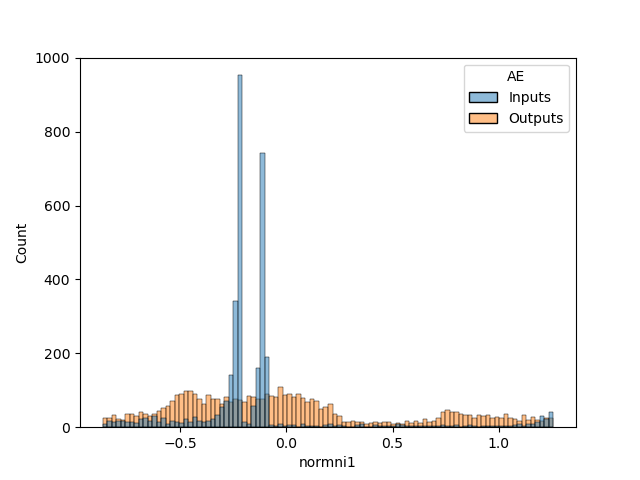

<IPython.core.display.Javascript object>


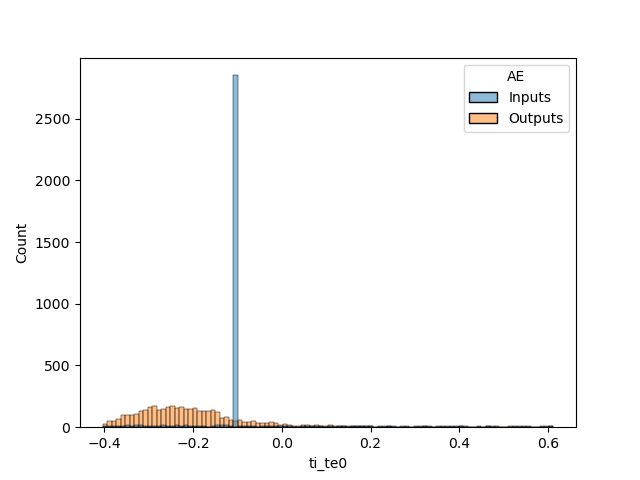

<IPython.core.display.Javascript object>


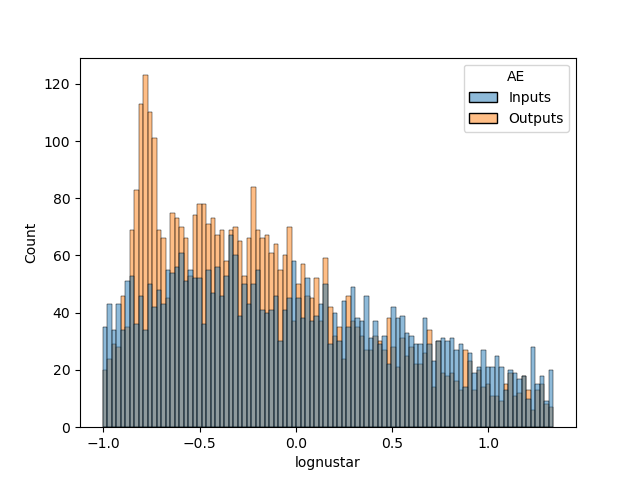

In [11]:
for i in train_keys:
    plt.figure()
    x_min = df_compare_sample[i].quantile(0.1)
    x_max = df_compare_sample[i].quantile(0.9)
    sns.histplot(data = df_compare_sample, x = i, hue = "AE", binrange = (x_min, x_max), bins = 100);
    plt.xlabel(i)

### Evaluate on all inputs

In [12]:
data_test_full = torch.from_numpy(df_full_test.values).float()
outputs_test_full = encoder.forward(data_test_full).detach().numpy()

In [13]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(outputs_test_full[:n,0], outputs_test_full[:n,1],outputs_test_full[:n,2])
fig.show()

<IPython.core.display.Javascript object>

In [ ]:
plt.figure()
sc = plt.scatter(outputs_test_full[:n,0], outputs_test_full[:n,1], c = outputs_test_full[:n,2])
plt.colorbar(sc)
plt.show()